,0,1,2,3,4
0,0,50,0,0,50
1,5,45,0,0,50
2,15,35,0,0,50
3,20,30,0,0,50
4,25,25,0,0,50


,EstebanRay,variance,carlosP,center-sq,center-abs
1,0.600000,0.3600,0.60,0.360,0.60
2,0.584217,0.3916,0.62,0.392,0.62
3,0.584965,0.4524,0.66,0.456,0.66
4,0.596331,0.4816,0.68,0.488,0.68
5,0.613902,0.5100,0.70,0.520,0.70


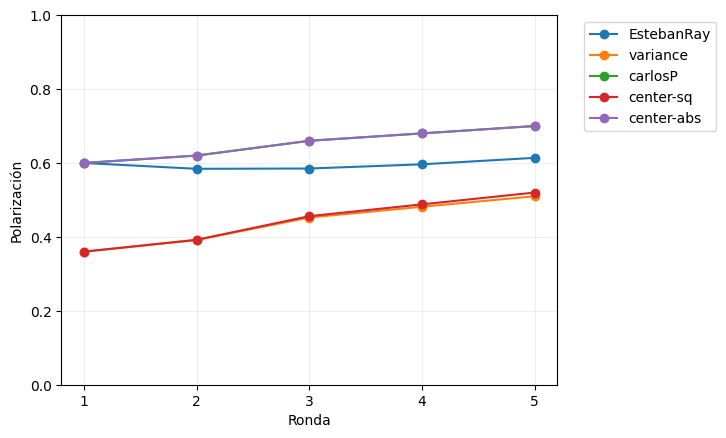

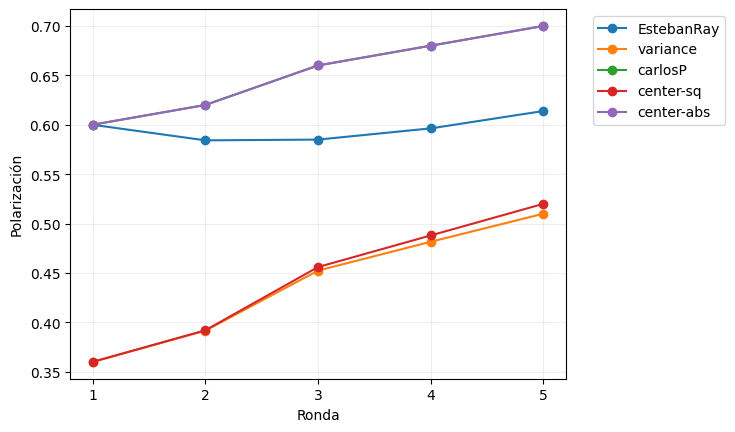

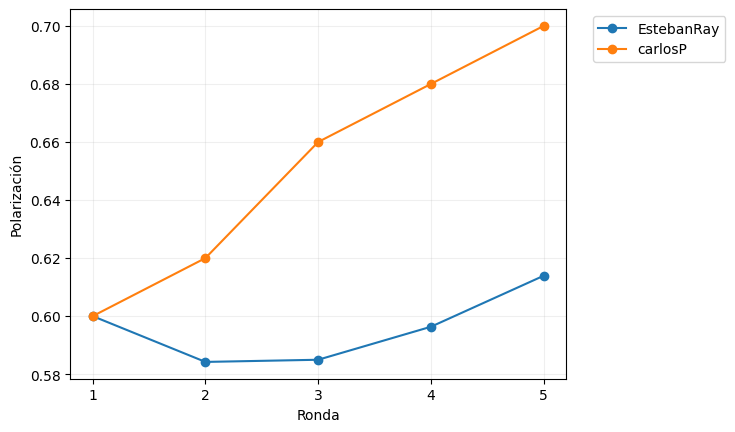

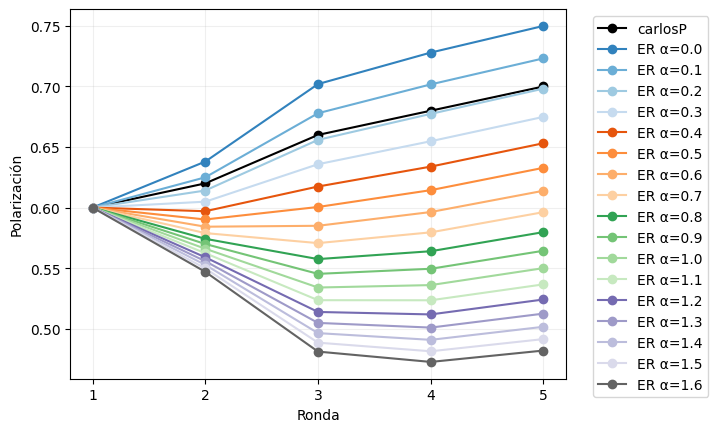

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler


class Survey:
    def __init__(self, opinions, counts=None):
        x = np.asarray(opinions, dtype=float)
        assert (
            0 <= x.min() <= x.max() <= 1
        ), f"Opinions out of range: {x.min()}, {x.max()}"

        x_unique, x_counts = np.unique(x, return_counts=True)
        if counts is None:
            x = x_unique
            counts = x_counts
        else:
            counts = np.asarray(counts)
            assert counts.shape == x.shape, f"Opinions and counts have different shapes"
            assert len(x_unique) == len(x), f"Expected unique opinions with counts"
        self.opinions = x
        self.counts = counts
        self.weights = counts / counts.sum()
        self.mu = np.average(x, weights=self.weights)

    @classmethod
    def test_max(cls):
        survey = cls([0, 1])
        for alpha in np.linspace(0, 1.6, 30):
            assert survey.metric_ER(alpha=alpha) == 1
        for name, value in survey.all_metrics().items():
            assert value == 1, f"{name} not equal to 1: {value}"
        return

    def metric_ER(self, alpha=None):
        """
        Esteban-Ray polarization:
        K * sum(pi**(1+alpha) * pj * abs(xi-xj) for xi, pi in zip(x, w) for xj, pj in zip(x, w))
        where K = 1 / 0.5**(1 + alpha) because K = 1 / sum_above_for(opinions=[0, 1])
        """
        if alpha is None:
            alpha = 0.6
        x, w = self.opinions, self.weights
        out = np.sum(w ** (1 + alpha) * w[:, None] * np.abs(x[:, None] - x))
        out /= 0.5 ** (1 + alpha)
        return out

    def metric_carlosP(self):
        """
        Metric proposed by Carlos Pinzón: 4 * p_left * p_right * (mean_right - mean_left)
        where the groups left and right are defined by thresholding the opinions at the mean.
        When the opinions match the mean, they can be assigned to any of the two groups (or none)
        without changing the output.
        """
        x, w = self.opinions, self.weights
        if np.all(x == self.mu):
            return 0
        L = x < self.mu
        R = ~L
        meanDiff = np.average(x[R], weights=w[R]) - np.average(x[L], weights=w[L])
        return 4 * w[L].sum() * w[R].sum() * meanDiff

    def metric_var(self):
        x, w = self.opinions, self.weights
        return 4 * np.average((x - self.mu) ** 2, weights=w)

    def metric_squared(self):
        x, w = self.opinions, self.weights
        return 4 * np.average((x - 0.5) ** 2, weights=w)

    def metric_abs(self):
        x, w = self.opinions, self.weights
        return 2 * np.average(np.abs(x - 0.5), weights=w)

    def all_metrics(self, alphas=None):
        metrics = {
            "EstebanRay": self.metric_ER(),
            "variance": self.metric_var(),
            "carlosP": self.metric_carlosP(),
            "center-sq": self.metric_squared(),
            "center-abs": self.metric_abs(),
        }
        if alphas is not None:
            del metrics["EstebanRay"]
            metrics.update(
                {f"ER α={round(alpha,3)}": self.metric_ER(alpha) for alpha in alphas}
            )
        return metrics


Survey.test_max()  # Test for maxPolarization


df_counts = pd.DataFrame(
    np.array(
        [
            [0, 50, 0, 0, 50],
            [5, 45, 0, 0, 50],
            [15, 35, 0, 0, 50],
            [20, 30, 0, 0, 50],
            [25, 25, 0, 0, 50],
        ]
    )
)
display(df_counts)

surveys = [Survey(np.arange(5) / 5, cnt) for cnt in df_counts.values]
n_rounds = len(surveys)
max_votes = max(df_counts.sum(axis=1))

metrics = pd.DataFrame(
    [survey.all_metrics() for survey in surveys], index=np.arange(n_rounds) + 1
)
display(metrics)

alphas = np.linspace(0, 1.6, 17)
alpha_metrics = pd.DataFrame(
    [survey.all_metrics(alphas) for survey in surveys], index=np.arange(n_rounds) + 1
).drop(columns=["center-abs", "center-sq", "variance"])

plt.style.context("fivethirtyeight")

for n_plot in range(1, 5):
    ax = plt.gca()

    df = metrics
    if n_plot == 3:
        df = df[["EstebanRay", "carlosP"]]
    if n_plot == 4:
        df = alpha_metrics
        ax.set_prop_cycle(cycler(color=["black", *plt.get_cmap("tab20c").colors]))

    df.plot(ax=ax, marker="o")
    ax.set_xticks(df.index)
    ax.set_ylabel("Polarización")
    ax.set_xlabel("Ronda")
    ax.grid(alpha=0.2)
    if n_plot == 1:
        ax.set_ylim([0, 1])
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

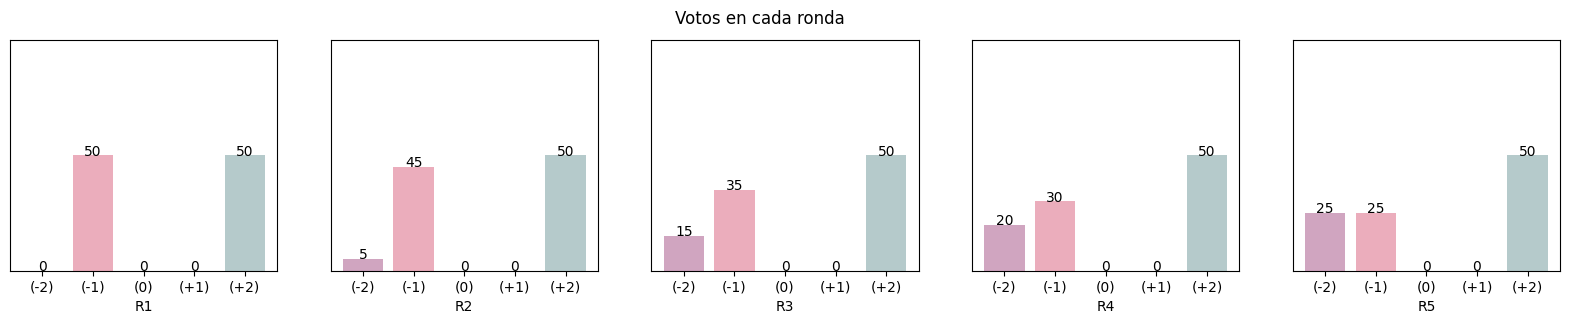

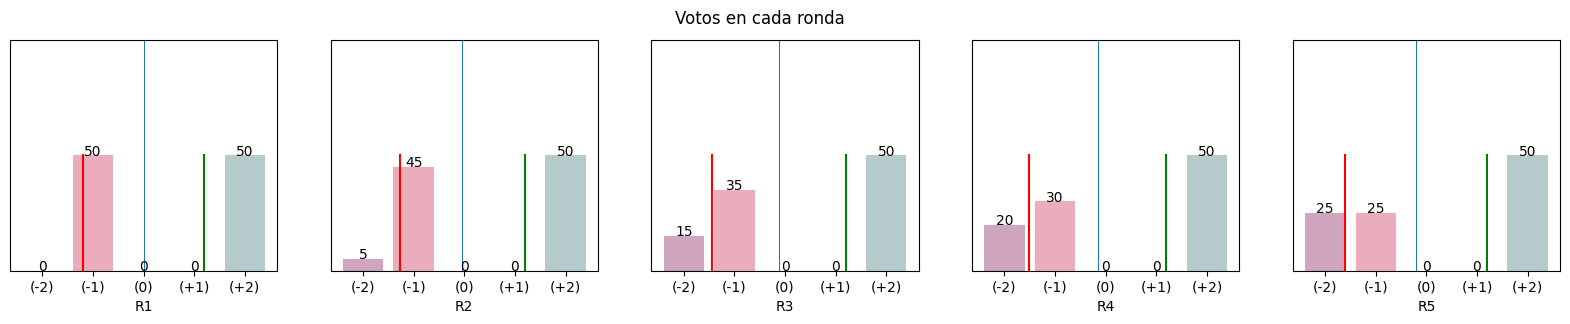

In [2]:
LTITLES = [
    "(-2) Totalmente en desacuerdo",
    "(-1) Moderadamente en desacuerdo",
    "( 0) Ni de acuerdo, ni en desacuerdo",
    "(+1) Moderadamente de Acuerdo",
    "(+2) Totalmente de Acuerdo",
]

LTITLES_SHORT = ["(-2)", "(-1)", "(0)", "(+1)", "(+2)"]
NUMBINS = len(LTITLES)
NUMCOLS = len(LTITLES_SHORT)
COLORS = [
    "#d0a5c0",
    "#ebadbc",
    "#f8d5b9",
    "#fef7c9",
    "#b5cacb",
    "#b5cacb",
    "#f5a87d",
] * 10
FIGSIZE = (20, 3)


for n_plot in range(1, 3):
    fig, axes = plt.subplots(1, n_rounds, figsize=FIGSIZE)
    fig.subplots_adjust(hspace=0.75)
    for i, survey in enumerate(surveys):
        ax = axes[i]
        ax.set_ylim([0, max_votes])
        ax.bar(LTITLES_SHORT, survey.counts, color=COLORS)
        ax.set_xlabel(f"R{i+1}")

        ax.tick_params(left=False, right=False, labelleft=False)
        for idx, value in enumerate(survey.counts):
            # ax.text(idx, value, f"{round(value*100)}%", ha="center")
            ax.text(idx, value, f"{value}", ha="center")

        if n_plot == 2:
            x = survey.opinions * 4
            w = survey.counts
            mu = np.average(x, weights=w)
            L = x <= mu
            R = ~L
            xL = np.average(x[L], weights=w[L])
            xR = np.average(x[R], weights=w[R])
            ax.plot([xL, xL], [0, w[L].sum()], color="red")
            ax.plot([xR, xR], [0, w[R].sum()], color="green")
            ax.axvline(mu, linewidth=0.75)

    fig.suptitle("Votos en cada ronda")
    plt.show()